# Open nanopore modbam2bed output

In [44]:
from Checkpoints import Checkpoint

nano_all = pd.read_csv('./data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed', sep="\t", 
                       names=["chromosome", "chromStart", "chromEnd", "mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])
nano_all["readCount_T"] = nano_all.loc[:, ("N_C", "N_mC", "N_hmC")].sum(axis="columns")
nano_all = filterReadCountNanopore(nano_all)
nano_all["percentMeth_C"] = nano_all.loc[:, "N_C"].divide(nano_all.loc[:, "readCount_T"]).multiply(100)
nano_all["percentMeth_hmC"] = nano_all.loc[:, "N_hmC"].divide(nano_all.loc[:, "readCount_T"]).multiply(100)
nano_all["percentMeth_mC"] = nano_all.loc[:, "N_mC"].divide(nano_all.loc[:, "readCount_T"]).multiply(100)

nano_mc_df = nano_all[["chromosome", "chromStart", "chromEnd", "strand", "readCount_T", "percentMeth_mC"]]
nano_hmc_df = nano_all[["chromosome", "chromStart", "chromEnd", "strand", "readCount_T", "percentMeth_hmC"]]


In [ ]:
from common import *

tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
oxbs_bed_path = './data/oxBS_data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'
wgbs_bed_path = './data/WGBS_data/mm39_ENCSR893RHD_merged.bed'

tab_df = filterDepth(get_bismark(tab_bed_path, "5hmC")).drop(columns=["modification_type", "method"])
oxbs_df = filterDepth(get_bismark(oxbs_bed_path, "5mC")).drop(columns=["modification_type", "method"])
wgbs_df = filterDepth(get_wgbs(wgbs_bed_path))


In [ ]:
ox_nano_mc = pd.merge(nano_mc_df, oxbs_df, "inner", ["chromosome", "chromStart", "chromEnd"])
ox_nano_hmc = pd.merge(nano_hmc_df, tab_df, "inner", ["chromosome", "chromStart", "chromEnd"])


In [ ]:
Checkpoint(ox_nano_mc, "mc_df_wide").saveCheckpoint()
Checkpoint(ox_nano_hmc, "hmc_df_wide").saveCheckpoint()

Checkpointing mc_df_wide.
Saved to ./intermediates/mc_df_wide.tsv.
Checkpointing hmc_df_wide.
Saved to ./intermediates/hmc_df_wide.tsv.


In [ ]:
from Checkpoints import Checkpoint

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()
if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

In [ ]:
def subtractionMethod(wgbs, comp):
    merged = pd.merge(wgbs, comp, "inner", on=["chromosome", "chromStart", "chromEnd", "strand"])
    if comp.columns.__contains__("percentMeth_oxBS_5mC"):
        merged["percentMeth_subtraction_5hmC"] = merged["percentMeth_WGBS"].subtract(merged["percentMeth_oxBS_5mC"])
    elif comp.columns.__contains__("percentMeth_TAB_5hmC"):
        merged["percentMeth_subtraction_5mC"] = merged["percentMeth_WGBS"].subtract(merged["percentMeth_TAB_5hmC"])
    return merged

sub_hmc = subtractionMethod(two_mod_wide, mc_df_wide)
sub_mc = subtractionMethod(two_mod_wide, hmc_df_wide)
sub_hmc_compare = pd.merge(sub_hmc, hmc_df_wide, "inner", on=["chromosome", "chromStart", "chromEnd", "strand"])
sub_mc_compare = pd.merge(sub_mc, mc_df_wide, "inner", on=["chromosome", "chromStart", "chromEnd", "strand"])
sub_hmc_compare

In [ ]:
from scipy import stats
from graphing import linePlot

stats.pearsonr(sub_hmc_compare["percentMeth_subtraction_5hmC"], sub_hmc_compare["percentMeth_Nanopore_5hmC"])
fig, ax = plt.subplots()

sns.set_palette("tab10")

ax.plot(np.arange(0, 101, 1), "black", linestyle=":")
linePlot(sub_mc_compare, ax)
linePlot(sub_mc_compare, ax, True)

# hMeDIP Comparison

In [ ]:
from common import *
import pandas as pd

hmedip_seq = pd.read_csv("../../data/cbm1_ip_13_07_23/cbm1_ip_13_07_23_modified_bases.bed", sep="\t", 
                         names=["chromosome", "chromStart", "chromEnd", "mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"]).query("readCount > 0")

## Questions

1. How many CpGs, of all CpGs, are hydroxymethylated in the IP vs. WGS?

In [ ]:
if not "wgs" in locals():
    wgs = pd.read_csv("./data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed", sep="\t", 
                      names=["chromosome", "chromStart", "chromEnd", "mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])

ip_ratio, wgs_ratio = hmedip_seq["N_hmC"].sum()/hmedip_seq["readCount"].sum(), wgs["N_hmC"].sum()/wgs["readCount"].sum()

print(f"IP: {ip_ratio}, WGS: {wgs_ratio}, IP/WGS: {round(ip_ratio/wgs_ratio, 3)}")

IP: 0.17132278207167603, WGS: 0.07351447326456936, IP/WGS: 2.33


2. What features are enriched in the IP vs. WGS? 

In [ ]:
import pyranges
from CpGIntersects import geneFeatureRefPyRange

hmedip_seq_pr = pyranges.PyRanges(hmedip_seq.rename(columns={"chromosome" : "Chromosome", "chromStart" : "Start", "chromEnd" : "End"}))
wgs_pr = pyranges.PyRanges(wgs.rename(columns={"chromosome" : "Chromosome", "chromStart" : "Start", "chromEnd" : "End"}))

ref_pr = geneFeatureRefPyRange().unstrand()

In [ ]:
ip_feats = hmedip_seq_pr.join(ref_pr, strandedness=None).as_df()
wgs_feats = wgs_pr.join(ref_pr, strandedness=None).as_df()

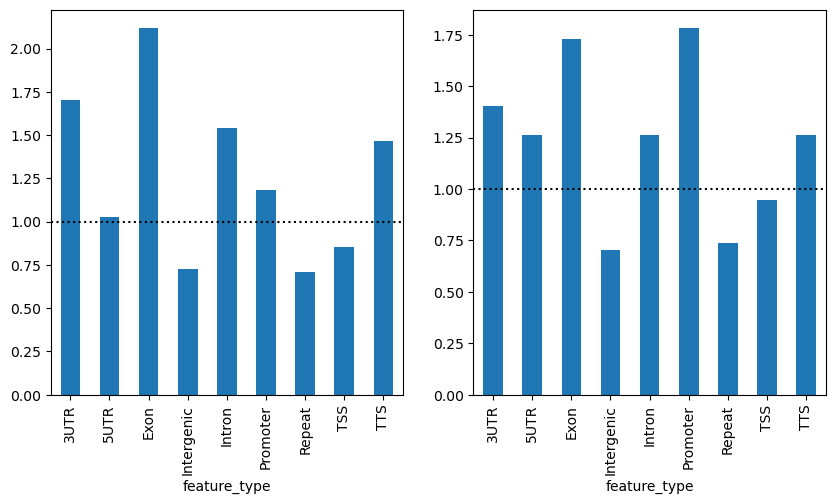

In [ ]:
fig, axes = plt.subplots(nrows= 1, ncols=2, figsize=(10, 5))

for index, data in enumerate(["readCount", "N_hmC"]):
    ip_feats_ratios = ip_feats.groupby("feature_type")[data].sum()/ip_feats[data].sum()
    wgs_feats_ratios = wgs_feats.groupby("feature_type")[data].sum()/wgs_feats[data].sum()
    feat_makeup = ip_feats_ratios/wgs_feats_ratios
    feat_makeup.plot.bar(ax=axes[index])
    axes[index].axhline(1.0, ls=":", c="black")

Genic elements are enriched in the IP data relative to WGS in terms of raw coverage. 

Promoters, and to a smaller degree genic elements, are overrepresented as a proportion of all 5hmC calls relative to WGS. 

3. What proportion of all reads are hydroxymethylated? 

In [4]:
from modbampy import ModBam
import pandas as pd
from common import *

ip_bam_path = "../../data/cbm1_ip_13_07_23/cbm1_ip_13_07_23_basecalls_sorted.bam"
    
def allCpGsInModBam(path):
    with ModBam(path) as bam:
        pos_all = []
        for locus in loadChromSize().to_dict("index").values():
            for read in bam.reads(locus["chromosome"], locus["chromStart"], locus["chromEnd"]):
                [pos_all.append([locus["chromosome"], locus["chromEnd"], *pos_mod]) for pos_mod in read.mod_sites]

    ps_df = pd.DataFrame(pos_all).drop(columns=[1, 5, 6, 7]).rename(columns={0 : "chromosome",
                                                                         2 : "readID",
                                                                         3 : "refPos", 
                                                                         4 : "qPos",                                                            
                                                                         8 : "modBase", 
                                                                         9 : "modScore"}).query("refPos != -1")

    return ps_df

def pivotToReads(cpg_df):
    pps_df = cpg_df.pivot(columns="modBase", index=["chromosome", "readID", "refPos"], values="modScore")
    pps_df.loc[pps_df.loc[:, "m"] <= (0.66*255), "m"], pps_df.loc[pps_df.loc[:, "m"] >= (0.66*255), "m"] = 0, 1
    pps_df.loc[pps_df.loc[:, "h"] <= (0.66*255), "h"], pps_df.loc[pps_df.loc[:, "h"] >= (0.66*255), "h"] = 0, 1
    
    return pps_df

def aggregateCpGsInReads(pivoted_df):
    agg_reads = pivoted_df.groupby(["readID"]).aggregate({"h" : sum,
                                                          "m" : sum})

    return agg_reads

In [ ]:
ip_reads = allCpGsInModBam(ip_bam_path)

In [ ]:
ip_reads = aggregateCpGsInReads(pivotToReads(allCpGsInModBam(ip_bam_path)))

In [ ]:
len(ip_reads.loc[ip_reads.loc[:, 'h'] > 0])

229004

In [ ]:
print(f"{len(ip_reads.loc[ip_reads.loc[:, 'h'] > 0])} reads ({round(len(ip_reads.loc[ip_reads.loc[:, 'h'] > 0])/len(ip_reads), 3)*100}%) reads contain 5hmC.")

229004 reads (47.4%) reads contain 5hmC.


4. How many 5hmCpGs per read? 

In [ ]:
ip_reads["h"].mean() # just under 1 5hmCpG per read

0.8930224850600188

<Axes: ylabel='Frequency'>

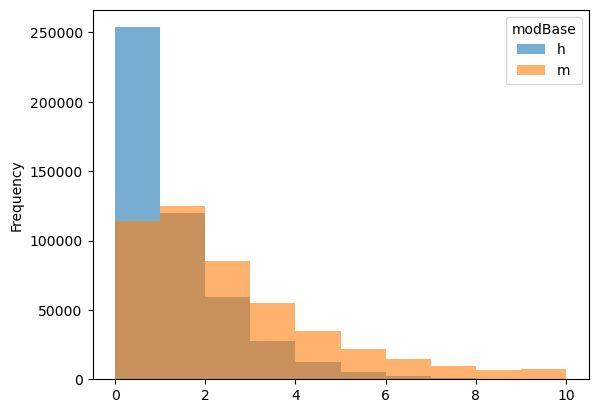

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

ip_reads.plot.hist(histtype='bar', alpha=0.6, stacked=False, bins=10, range=(0, 10), ax=ax)

5. How does this compare to WGS? 

In [37]:
from GroupCpGs import *
from Checkpoints import Checkpoint
from common import *
import pyranges as pr

if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

wgs_prable = changeColNamesForPR(hmc_df_wide)
wgs_ref = tiledGroup(CpGIntersects(wgs_prable).groupByGenomicWindow(564), 0).df

In [38]:
wgs_ref.loc[wgs_ref.loc[:, "Chromosome"] == "chrX"]

,Chromosome,Start,End,CpG_count,percentMeth_TAB_5hmC,percentMeth_Nanopore_5hmC
3137537,chrX,3053496,3054060,4,2.083333,0.000000
3137538,chrX,3054060,3054624,5,2.666667,0.000000
3137539,chrX,3055188,3055752,7,5.000000,0.000000
3137540,chrX,3055752,3056316,1,0.000000,0.000000
3137541,chrX,3056880,3057444,4,10.795455,1.562500
...,...,...,...,...,...,...
3318221,chrX,169254708,169255272,2,4.761905,11.688312
3318222,chrX,169255272,169255836,3,0.000000,1.960784
3318223,chrX,169258092,169258656,1,0.000000,10.000000
3318224,chrX,169258656,169259220,1,0.000000,0.000000


In [39]:
chrX_ranges = pr.PyRanges(changeColNamesForPR(loadChromSize())).tile(100000).as_df().query("Chromosome == 'chrX'").query("Start >= 3000000").query("Start <= 3100000")

In [36]:
from modbampy import ModBam

with ModBam("/mnt/data1/doh28/data/cbm1_wgs_26_06_23/dorado_0.3.1_basecalls/sorted/cbm1_wgs_26_06_23_merged.bam") as bam:
    

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


0              0                                     ...
1              0                                     ...
2              0                                     ...
3              0                                     ...
4              0                                     ...
                             ...                        
318           0                                     1...
319          0                                     1 ...
320           0                                     1...
321                Empty DataFrame
Columns: []
Index: []
322           0                                     1...
Name: 0, Length: 323, dtype: object

In [32]:
ps_df

,chromosome,readID,refPos,qPos,modBase,modScore
8,chrX,e57e8145-f01a-45d5-bef5-37a824517b8f,3050054,135,h,5
9,chrX,e57e8145-f01a-45d5-bef5-37a824517b8f,3050054,135,m,250
10,chrX,e57e8145-f01a-45d5-bef5-37a824517b8f,3050057,138,h,4
11,chrX,e57e8145-f01a-45d5-bef5-37a824517b8f,3050057,138,m,250
12,chrX,e57e8145-f01a-45d5-bef5-37a824517b8f,3050067,148,h,18
...,...,...,...,...,...,...
23275,chrX,cc12ccac-6957-4aa4-bd7e-259c4a9fee34,3204310,5018,m,188
23276,chrX,cc12ccac-6957-4aa4-bd7e-259c4a9fee34,3204610,5318,h,4
23277,chrX,cc12ccac-6957-4aa4-bd7e-259c4a9fee34,3204610,5318,m,251
23278,chrX,cc12ccac-6957-4aa4-bd7e-259c4a9fee34,3204945,5649,h,2


#### When filtered to non-repeat elements? 

In [4]:
import pyranges as pr
from CpGIntersects import geneFeatureRefPyRange

def makePyRangeFromModbamCpGs(modbam_cpgs):
    pyrangeable_df = modbam_cpgs.reset_index()
    pyrangeable_df.rename(columns={"chromosome" : "Chromosome",
                                   "refPos" : "Start"},
                          inplace=True)
    pyrangeable_df["End"] = pyrangeable_df["Start"].add(1)
    return pr.PyRanges(pyrangeable_df[["Chromosome", "Start", "End", "readID", "h", "m"]])


In [ ]:
ip_cpgs = pivotToReads(allCpGsInModBam(ip_bam_path))

In [ ]:
ip_cpgs_feat = makePyRangeFromModbamCpGs(ip_cpgs).join(geneFeatureRefPyRange().unstrand(), strandedness=None).as_df()

In [ ]:
ip_cpgs_feat.loc[(ip_cpgs_feat.loc[:, "feature_type"] != "Repeat")].groupby("readID").aggregate({"h" : sum, "m" : sum})["h"].mean()

0.9763383840999244

# Generating mlml-compatible datasets

In [ ]:
from common import *
import pandas as pd

wgbs_bed_path = './data/WGBS_data/mm39_ENCSR893RHD_merged.bed'
wgbs_df = get_wgbs(wgbs_bed_path)

oxbs_bed_path = './data/oxBS_data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed' 
oxbs_df = get_bismark(oxbs_bed_path, "5mC")

tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
tab_df = get_bismark(tab_bed_path, "5hmC")

In [ ]:
bisulphite_merged = filterDepth(wgbs_df).merge(
    filterDepth(oxbs_df), "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_WGBS", "_oxBS"]).merge(
        filterDepth(tab_df), "inner", ["chromosome", "chromStart", "chromEnd"]
        )
bisulphite_merged["context"] = "CPG"
bisulphite_merged.loc[:, ("percentMeth_WGBS", "percentMeth_oxBS", "percentMeth")] = bisulphite_merged.loc[:, ("percentMeth_WGBS", "percentMeth_oxBS", "percentMeth")].divide(100)

In [ ]:
bisulphite_merged.loc[:, ("chromosome", "chromStart", "strand", "context", "percentMeth_WGBS", "readCount_WGBS")].to_csv("./DNMTools_datasets/mm39_ENCSR893RHD_DNMToolsAlt_filtered.meth", sep="\t", header=None, index=False)
bisulphite_merged.loc[:, ("chromosome", "chromStart", "strand", "context", "percentMeth_oxBS", "readCount_oxBS")].to_csv("./DNMTools_datasets/mm39_oxBS_DNMToolsAlt_filtered.meth", sep="\t", header=None, index=False)
bisulphite_merged.loc[:, ("chromosome", "chromStart", "strand", "context", "percentMeth", "readCount")].to_csv("./DNMTools_datasets/mm39_TAB_DNMToolsAlt_filtered.meth", sep="\t", header=None, index=False)

# MLML comparison

In [ ]:
import numpy as np 

three_mod_bis = pd.read_csv('./DNMTools_datasets/dnmtoolsMLML_output.txt', sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_hmC", "percentMeth_C", "N_conflicts"])
three_mod_nano = pd.read_csv('./data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed', sep="\t", 
                             names=["chromosome", "chromStart", "chromEnd", "modification_type", "score", "strand", "i0", "i1", "i2", "readCount_ALL", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])

three_mod_nano["readCount"] = three_mod_nano["readCount_ALL"].subtract(
    np.add(three_mod_nano["N_filt"], three_mod_nano["N_NA"])
)

three_mod_nano = three_mod_nano.drop(columns=["modification_type", "score", "i0", "i1", "i2", "readCount_ALL", "N_filt", "N_NA"])

three_mod_nano["percentMeth_C"] = three_mod_nano["N_C"].divide(three_mod_nano["readCount"], axis=0)
three_mod_nano["percentMeth_hmC"] = three_mod_nano["N_hmC"].divide(three_mod_nano["readCount"], axis=0)
three_mod_nano["percentMeth_mC"] = three_mod_nano["N_mC"].divide(three_mod_nano["readCount"], axis=0)

three_mod_nano.replace(np.nan, 0)
three_mod_nano = three_mod_nano.loc[three_mod_nano["readCount"] >= 10]
three_mod_nano.drop(columns=["N_C", "N_mC", "N_hmC", "readCount"], inplace=True)

In [ ]:
merged_three_mod = pd.merge(three_mod_bis, three_mod_nano, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Bisulphite", "_Nanopore"])


In [ ]:
merged_three_mod = merged_three_mod[["chromosome", "chromStart", "chromEnd", "percentMeth_C_Bisulphite", "percentMeth_C_Nanopore", "percentMeth_mC_Bisulphite", "percentMeth_mC_Nanopore", "percentMeth_hmC_Bisulphite", "percentMeth_hmC_Nanopore", "strand"]]
merged_three_mod

,chromosome,chromStart,chromEnd,percentMeth_C_Bisulphite,percentMeth_C_Nanopore,percentMeth_mC_Bisulphite,percentMeth_mC_Nanopore,percentMeth_hmC_Bisulphite,percentMeth_hmC_Nanopore,strand
0,chr1,3070817,3070818,0.075949,0.000000,0.924051,0.869565,0.000000,0.000000,+
1,chr1,3070818,3070819,0.000000,0.047619,0.950000,0.904762,0.050000,0.000000,-
2,chr1,3070997,3070998,0.067515,0.157895,0.888044,0.631579,0.044441,0.052632,+
3,chr1,3070998,3070999,0.040000,0.062500,0.960000,0.750000,0.000000,0.062500,-
4,chr1,3071008,3071009,0.123457,0.157895,0.876543,0.736842,0.000000,0.052632,+
...,...,...,...,...,...,...,...,...,...,...
35919478,chrY,90756215,90756216,0.099197,0.114504,0.821103,0.480916,0.079700,0.091603,+
35919479,chrY,90756221,90756222,0.000000,0.084507,0.791667,0.464789,0.208333,0.098592,+
35919480,chrY,90756225,90756226,0.038902,0.054264,0.798754,0.573643,0.162344,0.062016,+
35919481,chrY,90756242,90756243,0.000000,0.083333,1.000000,0.568182,0.000000,0.037879,+


# MinION WGS Comparison

1. What is the approximate depth of the sample and how many CpGs are of sufficient depth? 

In [2]:
from common import readModbam2bedTernary

minion_cpgs = readModbam2bedTernary("./data/Nanopore_ternary_data/cbm1_wgs_26_06_23_modified-bases.bed")

In [ ]:
minion_cpgs_raw = pd.read_csv("./data/Nanopore_ternary_data/cbm1_wgs_26_06_23_modified-bases.bed", sep="\t", 
                         names=["chromosome", "chromStart", "chromEnd", "mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])

In [ ]:
minion_cpgs_raw["N_hmC"].sum()/minion_cpgs_raw["readCount"].sum()

0.06503038081598125

In [ ]:
len(minion_cpgs_raw.loc[(minion_cpgs_raw.loc[:, "N_hmC"] > 0)])/len(minion_cpgs_raw)

0.3253704874622543

<Axes: ylabel='Frequency'>

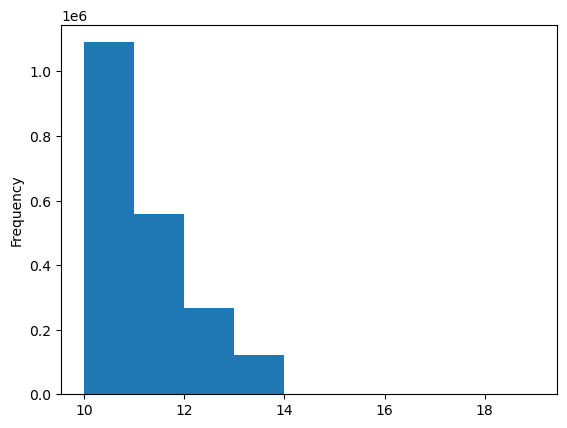

In [ ]:
import numpy as np 
minion_cpgs["readCount_T"].plot.hist(bins=list(np.arange(10, 20, 1)))

2. How well does this compare to the PromethION data? 

In [10]:
import pandas as pd 

if not "prom_data" or "min_data" in locals():
    prom_data = readModbam2bedTernary("./data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed")
    min_data = readModbam2bedTernary("./data/Nanopore_ternary_data/cbm1_wgs_26_06_23_modified-bases.bed")

merged_nanopore = pd.merge(prom_data, min_data, "inner", ["chromosome", "chromStart", "chromEnd", "strand"], suffixes=["_Prom", "_Min"])

In [38]:
from scipy import stats

stats.pearsonr(merged_nanopore["percentMeth_hmC_Min"], merged_nanopore["percentMeth_hmC_Prom"]), stats.spearmanr(merged_nanopore["percentMeth_hmC_Min"], merged_nanopore["percentMeth_hmC_Prom"])

(PearsonRResult(statistic=0.5446809127731452, pvalue=0.0),
 SignificanceResult(statistic=0.43615119504705196, pvalue=0.0))

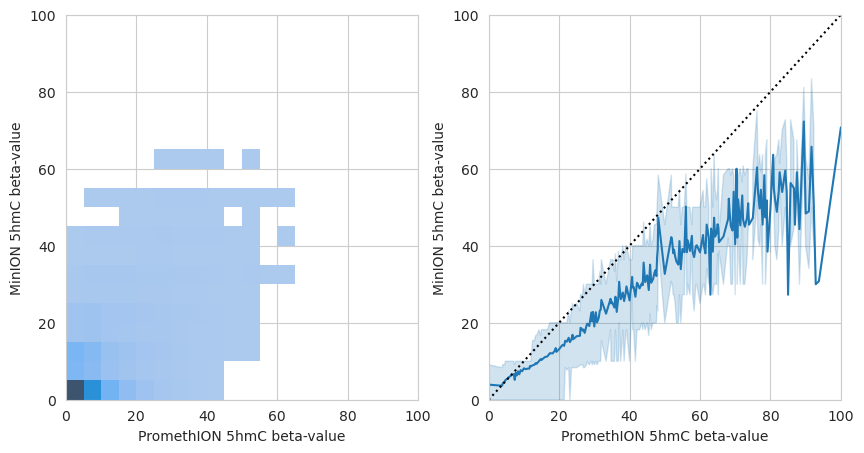

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(merged_nanopore, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", stat="proportion", pthresh=0.01, bins=20, ax=axes[0])
sns.lineplot(merged_nanopore, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", errorbar=("pi", 50), ax=axes[1])
axes[1].plot(np.arange(0, 101), ls=":", c="black")

for ax in axes:
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)
    ax.set_ylabel("MinION 5hmC beta-value")
    ax.set_xlabel("PromethION 5hmC beta-value")


How does this look resampled? See above.

In [90]:
def optimisedResample(merged_df, left, right):
    """
    Calculates the most common shared read count between two methods then extracts only CpG sites with that read count.
    :param str left: The column name for readcounts in the left dataframe.
    :param str right: The column name for readcounts in the right dataframe. 
    """
    resampling = merged_df.groupby([left])[right].value_counts().sort_values(ascending=False).reset_index(name="Count")
    maxid = resampling.loc[resampling.loc[:, left] == resampling.loc[:, right], "Count"].idxmax()
    most_common = resampling.iloc[maxid, :][left]
    count = resampling.iloc[maxid, :]["Count"]

    print(f"Most common readcount is {most_common} with {count} CpGs.")

    return merged_df.loc[(merged_df.loc[:, left] == most_common) & (merged_df.loc[:, right] == most_common)]


In [92]:
resampled_min_prom_data = optimisedResample(merged_nanopore, "readCount_T_Prom", "readCount_T_Min")

Most common readcount is 10 with 64847 CpGs.


In [96]:
stats.pearsonr(resampled_min_prom_data["percentMeth_hmC_Min"], resampled_min_prom_data["percentMeth_hmC_Prom"]), stats.spearmanr(resampled_min_prom_data["percentMeth_hmC_Min"], resampled_min_prom_data["percentMeth_hmC_Prom"])

(PearsonRResult(statistic=0.5035612658206317, pvalue=0.0),
 SignificanceResult(statistic=0.40988852402331627, pvalue=0.0))

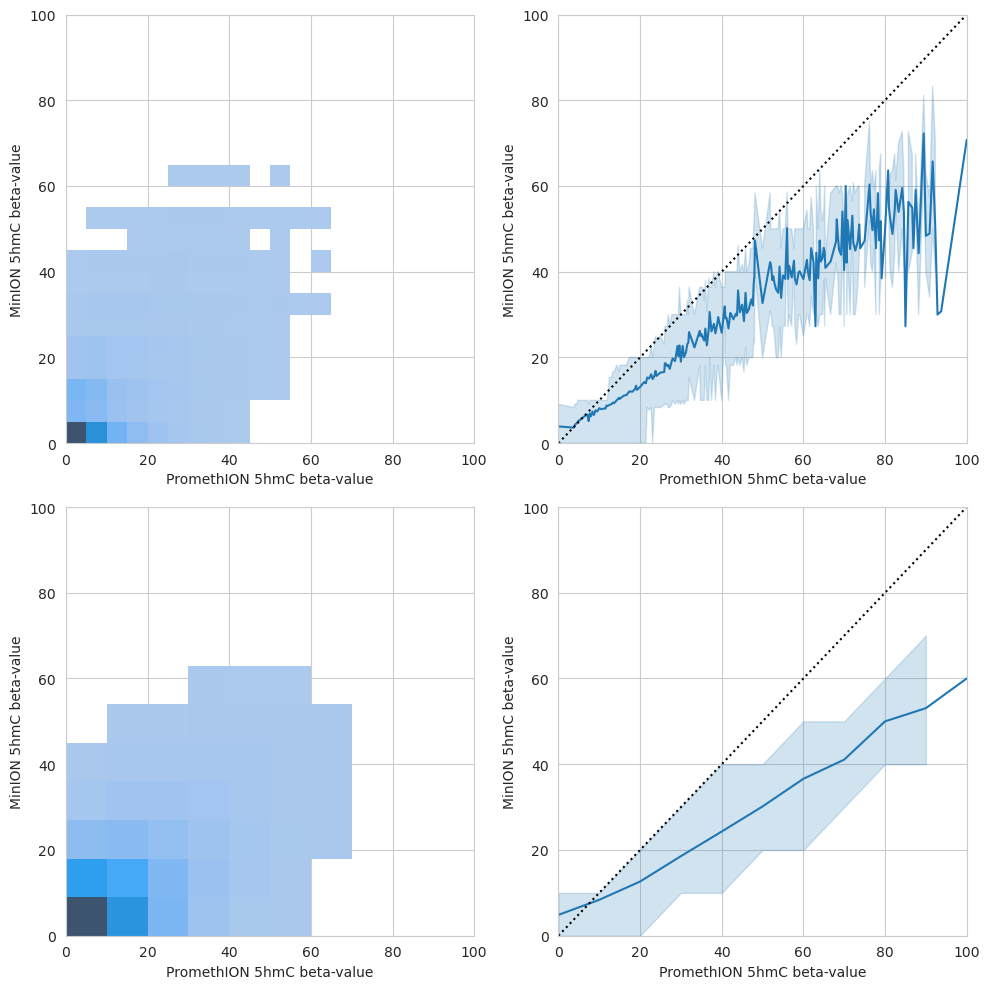

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(merged_nanopore, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", stat="proportion", pthresh=0.01, bins=20, ax=axes[0][0])
sns.lineplot(merged_nanopore, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", errorbar=("pi", 50), ax=axes[0][1])
sns.histplot(resampled_min_prom_data, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", stat="proportion", pthresh=0.01, bins=10, ax=axes[1][0])
sns.lineplot(resampled_min_prom_data, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", errorbar=("pi", 50), ax=axes[1][1])
axes[0][1].plot(np.arange(0, 101), ls=":", c="black")
axes[1][1].plot(np.arange(0, 101), ls=":", c="black")

for ax in axes[0]:
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)
    ax.set_ylabel("MinION 5hmC beta-value")
    ax.set_xlabel("PromethION 5hmC beta-value")
    
for ax in axes[1]:
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)
    ax.set_ylabel("MinION 5hmC beta-value")
    ax.set_xlabel("PromethION 5hmC beta-value")

plt.tight_layout()

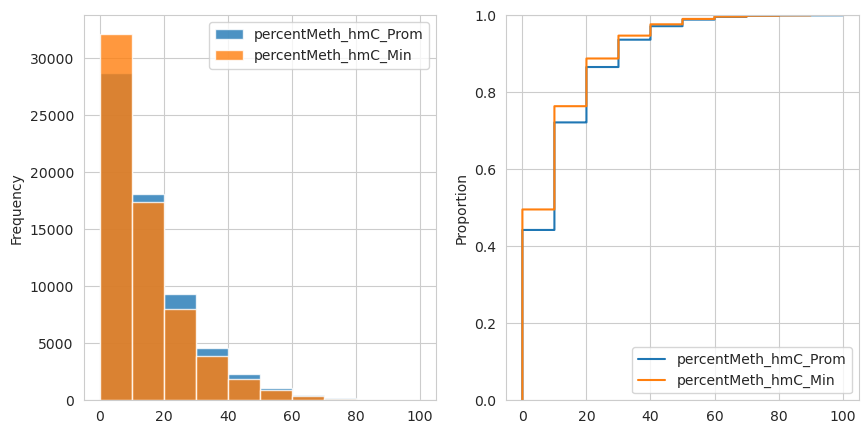

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

resampled_min_prom_data[["percentMeth_hmC_Prom", "percentMeth_hmC_Min"]].plot.hist(alpha=0.8, ax=axes[0])

for col in ["percentMeth_hmC_Prom", "percentMeth_hmC_Min"]:
    sns.ecdfplot(resampled_min_prom_data, label=col, x=col, ax=axes[1])
axes[1].set_xlabel(None)
axes[1].legend()

In [133]:
stats.ttest_ind(resampled_min_prom_data["percentMeth_hmC_Prom"], resampled_min_prom_data["percentMeth_hmC_Min"])

Ttest_indResult(statistic=18.610082692905646, pvalue=3.3576436738670598e-77)

## ModDF

In [ ]:
import subprocess
from Checkpoints import Checkpoint

class ModDF:
    def __init__(self, dataframe):
        self.dataframe = dataframe


class ModFile:
    def __init__(self, path):
        self.path = path
        self.modtype = None

    def readFirstLine(self):
        return subprocess.check_output(["head", "-n 1", f"{self.path}"]).decode("utf-8").split("\t")
    
    def checkModType(self):
        """
        Determines the type of modification in the given modification file. If the modification isn't specified in the file itself, then the file path will be parsed for it. 
        """
        first_line = self.readFirstLine()

        if first_line[3] == "5mC":
            self.mod_type = "5mC"
        elif first_line[3] == "5hmC":
            self.mod_type = "5hmC"
        else: 
            if self.path is not None and self.path.__contains__("oxBS") or self.path.__contains("5mC"):
                self.mod_type = "5mC"
            elif self.path is not None and self.path.__contains__("TAB") or self.path.__contains("5hmC"):
                self.mod_type = "5hmC"
            else:
                raise ValueError("Modification type isn't clear from the file or filepath.")
        return print(f"mod_type is {self.mod_type}")
    
    def loadAsDataframe(self):
        """
        Load the specified path as a dataframe type object.
        """
        return ModDF(pd.read_csv(f'{self.path}', sep="\t", header=None))
        

In [ ]:
def mergeMethods(bis_df, nano_df):
    bis_df, nano_df = map(lambda df: df.drop(columns=["method", "modification_type"]), [bis_df, nano_df])

    if "strand" in bis_df.columns and "strand" in nano_df.columns:
        wide_merged = pd.merge(bis_df, nano_df, "inner", 
                               ["chromosome", "chromStart", "chromEnd", "strand"], 
                               suffixes=["_Bisulphite", "_Nanopore"])
    else: 
        wide_merged = pd.merge(bis_df, nano_df, "inner", 
                               ["chromosome", "chromStart", "chromEnd"], 
                               suffixes=["_Bisulphite", "_Nanopore"])
    
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth"], i=["chromosome", "chromStart", "chromEnd", "strand"], 
                                  j="method", sep="_", suffix="\D+").reset_index()
    
    wide_merged = wide_merged[["chromosome", "chromStart", "chromEnd", "strand", "readCount_Bisulphite", "percentMeth_TAB", "readCount_Nanopore", "percentMeth_Nanopore"]]
    long_merged = long_merged[["chromosome", "chromStart", "chromEnd", "method", "strand", "readCount", "percentMeth"]]

    return wide_merged.reset_index(drop=True), long_merged

In [ ]:
two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)

## Bisulphite subtraction

In [ ]:
merged_wgbs_oxbs = pd.merge(wgbs_df, oxbs_df, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_WGBS", "_oxBS"])

In [ ]:
merged_wgbs_oxbs["percentMeth_Subtraction_5hmC"] = np.subtract(merged_wgbs_oxbs["percentMeth_WGBS"], merged_wgbs_oxbs["percentMeth_oxBS"])

In [ ]:
merged_wgbs_oxbs_wTAB = pd.merge(merged_wgbs_oxbs, tab_df, "inner", ["chromosome", "chromStart", "chromEnd"])

In [ ]:
merged_wgbs_oxbs_wTAB.loc[merged_wgbs_oxbs_wTAB["percentMeth_Subtraction_5hmC"] < 0, "percentMeth_Subtraction_5hmC"] = 0

In [ ]:
from scipy import stats

r = stats.pearsonr(merged_wgbs_oxbs_wTAB["percentMeth_Subtraction_5hmC"], merged_wgbs_oxbs_wTAB["percentMeth"])[0]

In [ ]:
merged_wgbs_oxbs_wTAB["bench_bin"] = pd.cut(merged_wgbs_oxbs_wTAB["percentMeth"], 51, labels=np.arange(0, 102, 2))

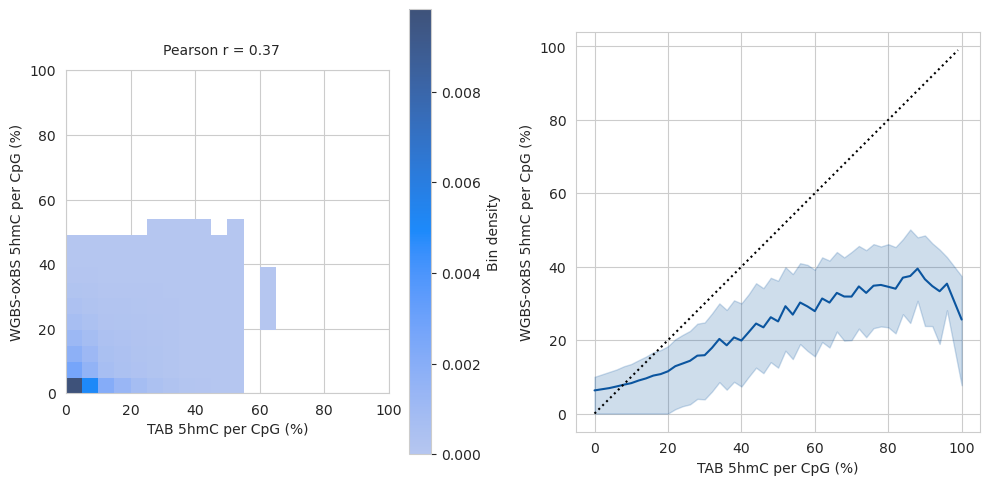

In [ ]:
from scipy import stats
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
# sns.set_palette("Blues_r")

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, fig)

ax = fig.add_subplot(gs[0, 0])

sns.histplot(merged_wgbs_oxbs_wTAB, x="percentMeth", y="percentMeth_Subtraction_5hmC", bins=20, pthresh=0.01, stat="density", cbar=True, cbar_kws={"label" : "Bin density"}, ax=ax)
ax.text(30, 105, "Pearson r = {r:.2f}".format(r=(r), ha="center"))
ax.set_xlim((0, 100))
ax.set_ylim((0, 100))
ax.set_ylabel("WGBS-oxBS 5hmC per CpG (%)")
ax.set_xlabel("TAB 5hmC per CpG (%)")
ax.set_aspect("equal")

ax2 = fig.add_subplot(gs[0, 1])
sns.lineplot(merged_wgbs_oxbs_wTAB, x="bench_bin", y="percentMeth_Subtraction_5hmC", errorbar=("pi", 50), ax=ax2)
ax2.plot(np.arange(0, 100), color="black", linestyle=":")
ax2.set_ylabel("WGBS-oxBS 5hmC per CpG (%)")
ax2.set_xlabel("TAB 5hmC per CpG (%)")
ax2.set_aspect("equal")

fig.tight_layout()


# Locus level class definitions

## ConfusionMatrix

In [ ]:
mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from Checkpoints import Checkpoint

def merge3Mod(): 
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

    mc_df_wide, hmc_df_wide = map(lambda df: df.drop(columns=["readCount_Bisulphite", "readCount_Nanopore"]), [mc_df_wide, hmc_df_wide])

    merged_df = pd.merge(mc_df_wide, hmc_df_wide, "inner", ["chromosome", "chromStart", "chromEnd", "strand"], suffixes=["_5mC", "_5hmC"])
    return merged_df
    
def defineTruthset():
    truth_list = np.select(
        [Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_TAB_5hmC"].gt(50), 
         Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_oxBS_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return truth_list

def definePredictions():
    prediction_list = np.select(
        [Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Nanopore_5hmC"].gt(50), 
         Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Nanopore_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return prediction_list
    
def binBenchmark(wide_df):
    wide_df["bin"] = pd.cut(wide_df["percentMeth_Bisulphite"], 51, labels=np.arange(0, 102, 2))
    return wide_df

def calcChiSquare(wide_df):
    x = pd.cut(wide_df["percentMeth_Bisulphite"], 21, labels=np.arange(0, 105, 5)).value_counts()
    y = pd.cut(wide_df["percentMeth_Nanopore"], 21, labels=np.arange(0, 105, 5)).value_counts()
    return stats.chisquare(x, y)

In [ ]:
defineTruthset()

array(['5mC', 'C', '5mC', ..., 'C', 'C', '5mC'], dtype='<U4')

In [ ]:
Checkpoint(merge3Mod()).saveCheckpoint(name="three_state_comparison") 

In [ ]:
hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()
mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()

# Macro-scale 5hmC analysis

These figures compare 5hmC calling at the level of larger elements, including whole genes and 1kb windows. The focus of these images is on 5hmC - given that this is the modified base with lower apparent classification agreement (see above)

In [ ]:
def threeModDFtohmCPyrange():
    """
    Produces a PyRange object using only the 5hmC comparison data. 
    """
    data = Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint(
        colnames=["chromosome", "chromStart", "chromEnd", "strand", 
                  "percentMeth_Bisulphite_5mC", "percentMeth_Nanopore_5mC", 
                  "percentMeth_Bisulphite_5hmC", "percentMeth_Nanopore_5hmC"])
    pyrange = pr.from_dict({
        "Chromosome" : data["chromosome"],
        "Start" : data["chromStart"],
        "End" : data["chromEnd"],
        "Strand" : data["strand"],
        "percentMeth_Nanopore_5hmC" : data["percentMeth_Nanopore_5hmC"], 
        "percentMeth_Bisulphite_5hmC" : data["percentMeth_Bisulphite_5hmC"]
        }
        )
    return pyrange
    
Checkpoint(dataframe=threeModDFtohmCPyrange().as_df(), name="three_mod_pyrange").saveCheckpoint()

In [ ]:
from Checkpoints import Checkpoint

pyrange_data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

## Histograms with feature positions

In [ ]:
from FeatureReferences import Features
from Checkpoints import Checkpoint

repeats = Features('./feature_references/revised/repeats/UCSC_rmsk_mm39_Repeat.bed')
promoters = Features('./feature_references/revised/gene_features/name_adjusted/ENSEMBL_regFeatures_mm39_Promoter_wStrands.bed')

data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

In [ ]:
import pyranges as pr

repeats_data = pr.PyRanges(data).join(pr.PyRanges(repeats.dataframe)).as_df()
promoters_data = pr.PyRanges(data).join(pr.PyRanges(promoters.dataframe)).as_df()

Text(0, 0.5, 'Nanopore enrichment')

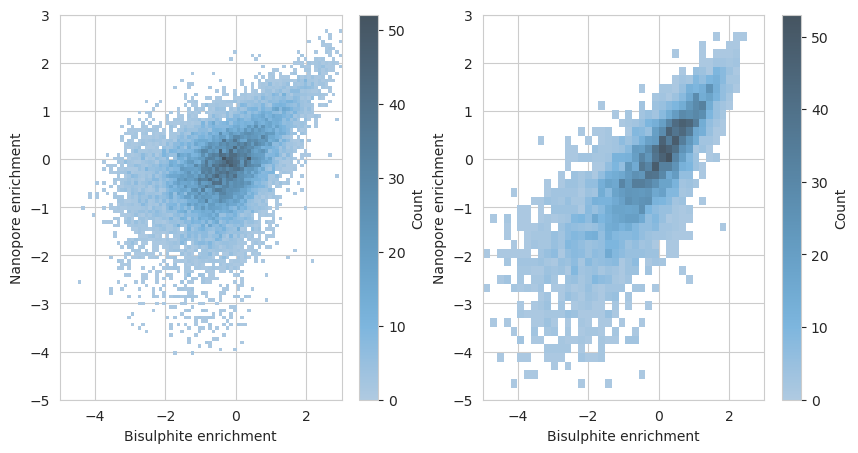

In [ ]:
from GroupCpGs import *
from CpGIntersects import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
sns.set_palette("Blues")

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, fig)

ax1 = fig.add_subplot(gs[0, 0])
FeatureAndGene(CpGIntersects(repeats_data).group("other"), 10).makeHist("count", ax1)
ax1.set_ylim((-5, 3))
ax1.set_xlim((-5, 3))
ax1.set_xlabel("Bisulphite enrichment")
ax1.set_ylabel("Nanopore enrichment")

ax2 = fig.add_subplot(gs[0, 1])
FeatureAndGene(CpGIntersects(promoters_data).group("other"), 10).makeHist("count", ax2)
ax2.set_ylim((-5, 3))
ax2.set_xlim((-5, 3))
ax2.set_xlabel("Bisulphite enrichment")
ax2.set_ylabel("Nanopore enrichment")

Text(0.5, 1.0, 'Repeats')

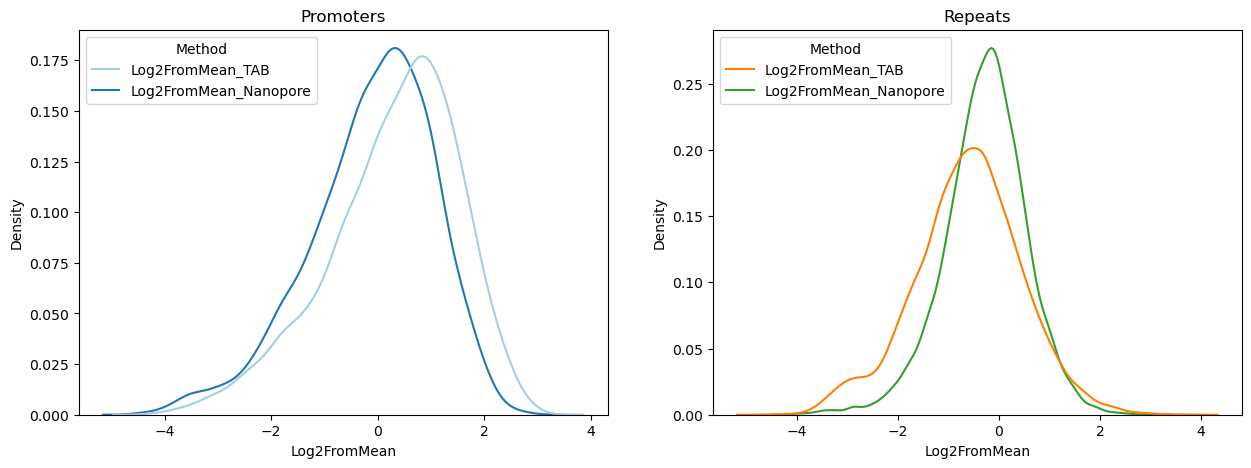

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from GroupCpGs import *

repeats_promoters = pd.concat([FeatureAndGene(CpGIntersects(repeats_data).group("other"), 10).df, 
                               FeatureAndGene(CpGIntersects(promoters_data).group("other"), 10).df])

repeats_promoters = FeatureAndGene(repeats_promoters, 10).dfWithLogCols()
repeats_promoters_melted = repeats_promoters.melt(["Name", "feature_type", "group_start", "group_end"], ["Log2FromMean_TAB", "Log2FromMean_Nanopore"], var_name="Method", value_name="Log2FromMean")

fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0), fig=fig)
sns.kdeplot(repeats_promoters_melted.loc[repeats_promoters_melted["feature_type"] == "Promoter"], x="Log2FromMean", hue="Method", palette="Paired", ax=ax1)
ax1.set_title("Promoters")

ax2 = plt.subplot2grid((1, 2), (0, 1), fig=fig)
sns.kdeplot(repeats_promoters_melted.loc[repeats_promoters_melted["feature_type"] == "Repeat"], x="Log2FromMean", hue="Method", palette="Paired_r", ax=ax2)
ax2.set_title("Repeats")


This would indicate that 5hmC is not consistent at each feature. Promoters appear to be more strongly hydroxymethylated (vs. mean) in TAB than Nanopore, and there is a greater tendency for repeat regions to be detected as _more hydroxymethylated_ relative to genomic mean hydroxymethylation in Nanopore than in TAB.

In [ ]:
import pyBigWig # required for bigWig output of pr 

def makeChromSizes():
    init = pd.read_csv('./feature_references/revised/mm39.chrom.sizes', sep="\t", names=["Chromosome", "End", "Start"])
    init["Start"] = 0
    init = init[["Chromosome", "Start", "End"]]
    return pr.PyRanges(init).sort()

In [ ]:
# three_mod_pr.to_bigwig('./outputs/nanopore_5hmC_chr1.bw', chromosome_sizes=makeChromSizes(), value_col="percentMeth_Nanopore_5hmC")

# Read level information at imprinted and non-imprinted sites

These scripts extract read level information from the modified bam files and perform clustering based on CpG site methylation states. The resulting clustermaps help to clearly show CpG sites with similar modification status. 

Of note, CpG sites are here aggregated (merged + and - strands) for ease of visualisation. 

In [ ]:
from modbampy import ModBam
import pandas as pd
import pyranges as pr
import numpy as np

In [ ]:
grb10_pr = pr.PyRanges(chromosomes="chr11", starts=[11878499], ends=[11989420], int64=True) # grb10 used here as an example (start/end coordinates based on mm39)
tiled_grb10_df = grb10_pr.tile(3000).as_df()
tiled_grb10_dict = tiled_grb10_df.to_dict("index")

In [ ]:
with ModBam('./data/prom_R10.4.1_E8.2_WGS_brain_DH_grb10.bam') as bam:
    tile_list = []
    tile_id = 1
    for tile in tiled_grb10_dict.values():
        read_list = []
        for read in bam.reads(tile["Chromosome"], tile["Start"], tile["End"]):
            read_sites = []
            for mod_position in read.mod_sites:
                mod_position_info = [tile_id, tile["Chromosome"], tile["Start"], tile["End"]]
                for datum in mod_position:
                    mod_position_info.append(datum)
                read_sites.append(mod_position_info)
            read_list.extend(read_sites)
        tile_list.extend(read_list)
        tile_id += 1 
names=["tile", "chromosome", "chromStart", "chromEnd", "read", "refPos", "qPos", "refStrand", "modStrand", "base", "mod", "score"]
tile_df = pd.DataFrame(tile_list, columns=names)
    
def filterTile(tile): 
    # tile_df.loc[tile_df["refStrand"] == "-", "refPos"] = tile_df["refPos"].sub(2, axis=0)
    one_tile_df = tile_df.loc[(tile_df["tile"] == tile) & (tile_df["refPos"].ge(tile_df["chromStart"])) & (tile_df["refPos"].lt(tile_df["chromEnd"]))] 
    
    tile_df_pivot1 = one_tile_df.pivot(index=["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], columns="mod", values="score").reset_index()
    tile_df_pivot1["c"] = 255 - tile_df_pivot1[["h", "m"]].sum(axis=1)
    tile_df_melt = pd.melt(tile_df_pivot1, ["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], ["h", "m", "c"], "mod", "score")
    tile_df_melt = tile_df_melt.loc[tile_df_melt["score"] >= 0.66*255]
    tile_df_melt.loc[tile_df_melt["refStrand"] == "-", "refPos"] = tile_df_melt["refPos"].sub(1, axis=0)

    return tile_df_melt.reset_index(drop=True)

def pivotToHeatmap(df):
    df = df.pivot(index="read", columns=["refPos"], values="mod")
    df[df == "c"] = 0
    df[df == "h"] = 2
    df[df == "m"] = 1
    
    return df

def NADropper(df):
    new_df = df.dropna(thresh=len(df)*0.2, axis="columns") # removes CpGs present in fewer than 20% of reads
    new_df = new_df.dropna(thresh=len(new_df.columns)*0.50, axis="index") # removes reads with fewer than x% of CpGs
    return new_df

def makeHeatmap(tile):

    data = NADropper(pivotToHeatmap(filterTile(tile)))

    fig = sns.clustermap(data.fillna(-1), 
                mask=data.isna(), 
                xticklabels=10, yticklabels=False,
                col_cluster=False, row_cluster=True, 
                cmap=sns.color_palette("Blues", 3),
                cbar_kws={"ticks" : [0, 1, 2],
                        "orientation" : "horizontal"},
                figsize=(10, 10))

    fig.ax_cbar.set_position([0.40, 0.85, 0.3, 0.03])
    fig.ax_cbar.set_xticks([0.33, 1, 1.66])
    fig.ax_cbar.set_xticklabels(["C", "5mC", "5hmC"])
    fig.ax_cbar.set_title("Modification type", fontdict={"fontsize" : 10})
    fig.ax_heatmap.set_ylabel("Read")
    fig.ax_heatmap.set_xlabel("CpG position")

    return fig

In [ ]:
import numpy as np

def makeTileHeatmaps():
    for tile in np.arange(1, 39, 1):
        fig = makeHeatmap(tile)
        fig.savefig(f'./outputs/Grb10_heatmaps/tile_{tile}_heatmap.png', dpi=600)
        plt.close(fig)
    return 

makeTileHeatmaps()

NameError: name 'makeHeatmap' is not defined